In [1]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 13,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [2]:
#Take the fits file to pandas for the analysis code, we only use the mu=1 data
with fits.open(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Spatially Resolved Atlas\solarspectrum_mu1.fits") as hdul:
    tabla = hdul[0].data

table = pd.DataFrame(tabla)

In [3]:
#Create the dataframe of raw data
raw_data = pd.DataFrame()
raw_data['Wave A'] = np.array(table.iloc[0].tolist())
raw_data['nFlux'] = np.array(table.iloc[1].tolist())
raw_data


,Wave A,nFlux
0,4200.000,0.873086
1,4200.001,0.875943
2,4200.002,0.879616
3,4200.003,0.884252
4,4200.004,0.887163
...,...,...
3799996,7999.996,0.974642
3799997,7999.997,0.974583
3799998,7999.998,0.974533
3799999,7999.999,0.974483


In [4]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


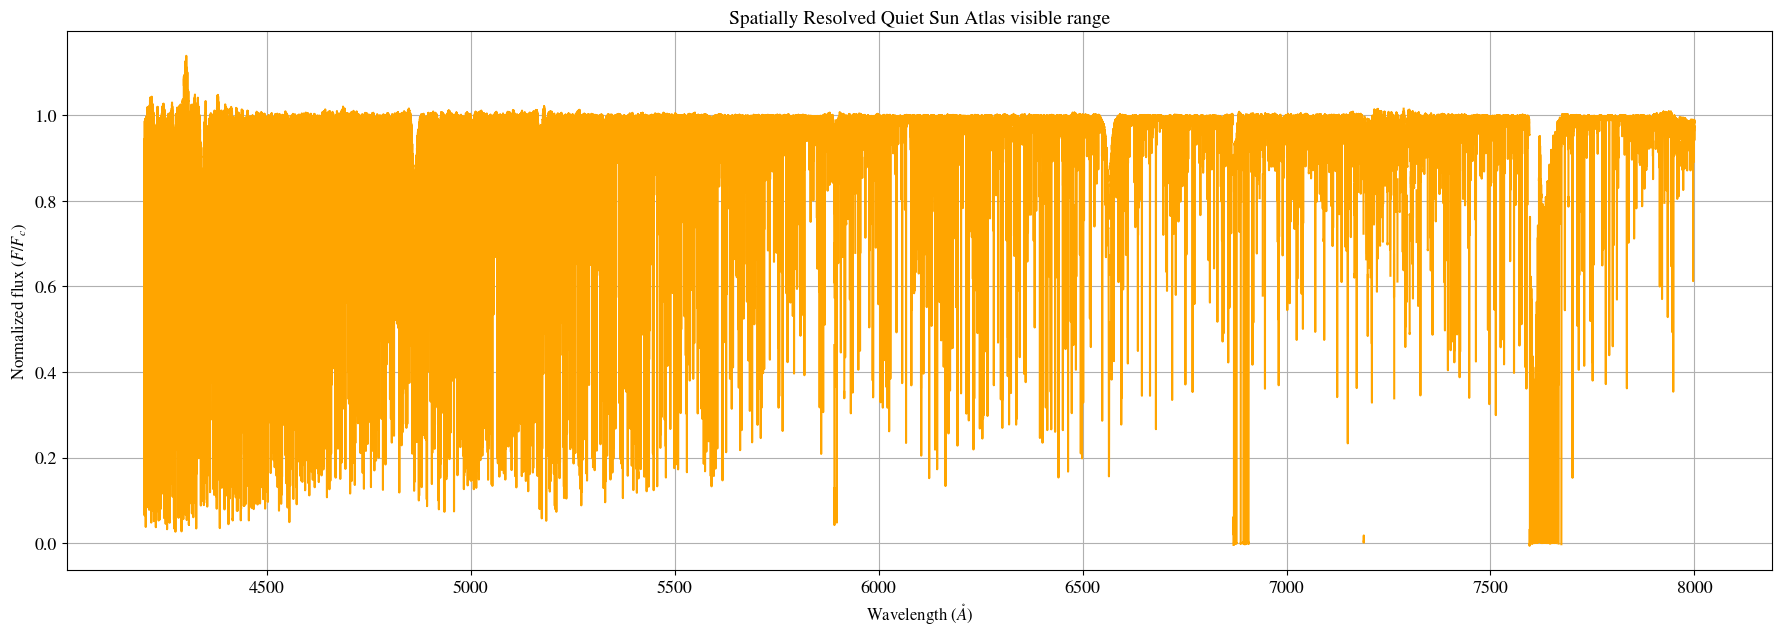

In [5]:
#Plot of raw data
fig1, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Spatially Resolved Quiet Sun Atlas visible range',fontsize=14)
ax.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=12)
ax.set_ylabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.grid()

# fig1.savefig('Spectrum_SPA.png')

### Find the minimums and the closer line of the Fe I line


In [6]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.025].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

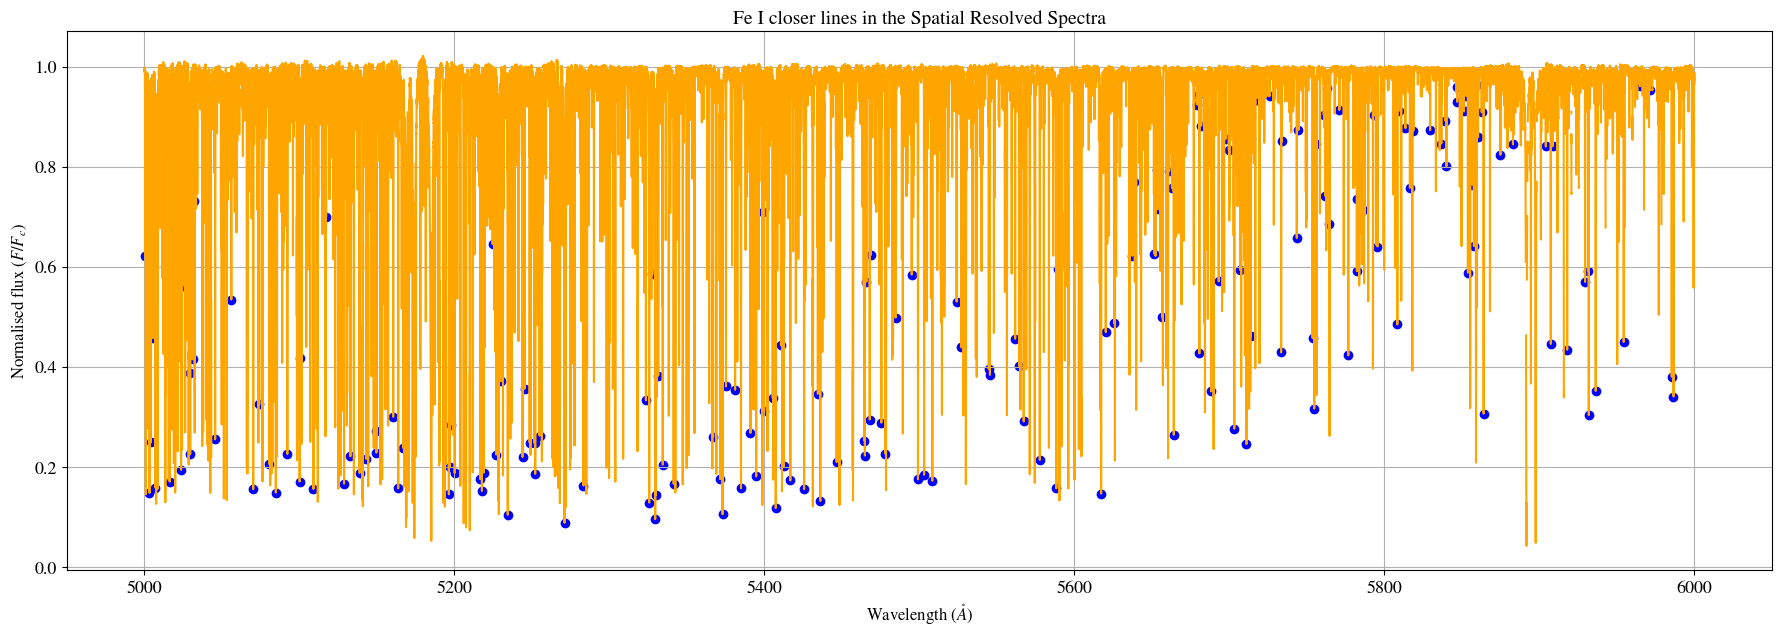

In [7]:
#Plot the identified lines
fig2, ax = plt.subplots(1,1,figsize=(22,7))

#Just for the plot, separte in the range 5000-6000 A
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000,6000,inclusive='right')]
closer_lines_5000_6000 = closer_lines[closer_lines['Fe line'].between(5000,6000,inclusive='right')]

ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')

ax.set_title('Fe I closer lines in the Spatial Resolved Spectra')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel(r'Normalised flux $(F/F_{c})$')
ax.grid()

In [8]:
#Localize the line and save the width for each one
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)#The range is 0.05mA

### Derivates and fit

In [22]:
def Fit_derivates(local_points,lamda_list,N):
    values = []
    fit = []
    cov = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Use polyfit only for the covariance matrix

        #Define new data with the number of points for the points, this is just for the statistical analysis
        new_wave = np.linspace(min(wave_scaled),max(wave_scaled),N)
        new_flux = np.linspace(min(data_flux),max(data_flux),N)

        #Covariance matrix for the polynomial fit coefficients scaled for the standarization
        _ , cov_matrix = np.polyfit(new_wave, new_flux, 4,cov=True)

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values, taking into account the number of points defined on the covariance matrix
        flux_fit = poly.polyval(new_wave,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift,line depth
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift,1-lamda_obs[1]]])) 

            #Just in case of the visualizer take the fit values and the wave data scaled
            fit.append(pd.DataFrame({'Flux': flux_fit,'Wave': new_wave*wave_std + wave_mean}))

            #STATISTICS 
            #Scale the matrix of covariance
            cov_b = cov_matrix*wave_std

            #Second derivate but without scale
            d2_scale = poly.polyval(minimal_root[0],d2_param)

            #Gradient for derivates of coeficients with the wavelength without scale
            grad_wave = np.array([-(4*minimal_root[0]**3) / d2_scale,-(3*minimal_root[0]**2) / d2_scale, -(2*minimal_root[0]) / d2_scale,-1 / d2_scale,0  ])

            #Scale the gradient
            grad_wave = grad_wave*wave_std

            #Add the covariance and the varince of the minimum point (observed wavelength), and for the velocity
            var = grad_wave @ cov_b @ grad_wave.T
            cov.append(pd.DataFrame({'Var': var,'Error': np.sqrt(abs(var)),'Error v': (const.c / lamda_list[i]) * np.sqrt(abs(var))},index=[0]))

    Values =  pd.concat(values,axis=0).reset_index(drop=True)
    Cov =  pd.concat(cov,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift",'Line Depth']

    return Values,fit,Cov

#The len(local_points) is for the original set, without statistical treatment.
Values,Fit,Cov = Fit_derivates(local_points,closer_lines['Fe line'],len(local_points))

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,Core curvature,Bisector slope,Blueshift,Line Depth
0,4202.1078,4202.1137,0.120261,-212,7.956737e+09,-4.021431e+07,420.925780,0.879739
1,4203.9370,4203.9391,0.251287,-483,1.347787e+10,-4.979322e+05,149.755851,0.748713
2,4206.7233,4206.7272,0.169646,-355,9.554437e+09,-2.321649e+07,277.933799,0.830354
3,4208.3123,4208.3170,0.111958,-298,1.008069e+10,-1.539483e+07,334.819389,0.888042
4,4209.7896,4209.7963,0.124643,-156,7.800363e+09,-8.095893e+07,477.128232,0.875357
...,...,...,...,...,...,...,...,...
473,7915.0437,7915.0519,0.600122,-322,1.304837e+10,-5.482679e+06,310.585544,0.399878
474,7943.2736,7943.2820,0.646910,-316,1.120859e+10,-3.773796e+05,317.030078,0.353090
475,7948.0326,7948.0484,0.353683,-37,6.195299e+09,-2.732089e+07,595.961425,0.646317
476,7957.1226,7957.1302,0.929205,-347,2.393041e+09,3.897903e+07,286.337511,0.070795


In [23]:
# #Convert to excel
# Values.to_excel('values_SPA.xlsx', index=False)

## Graphics 

As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

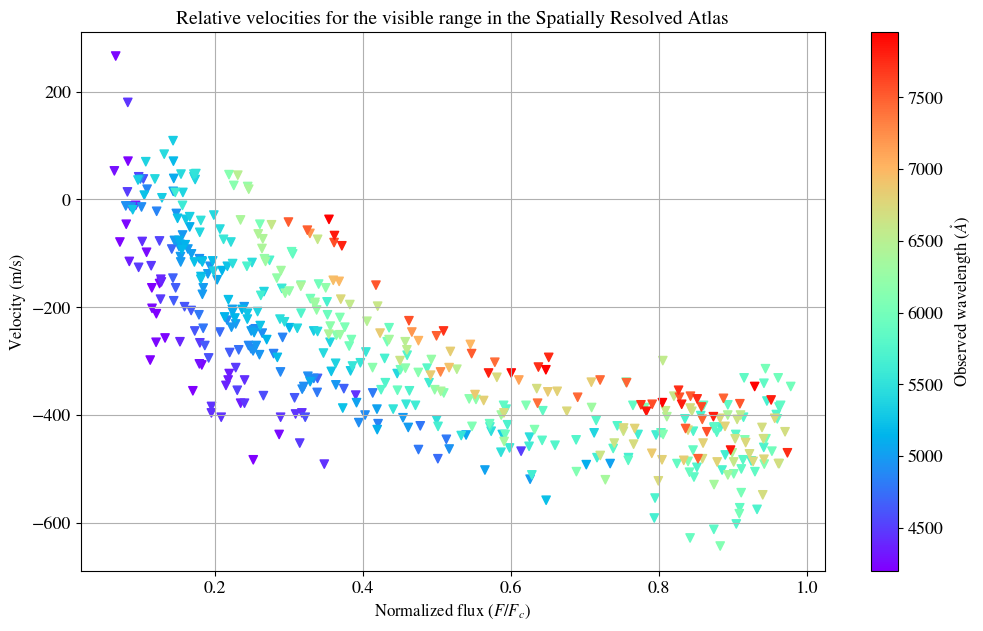

In [24]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Relative velocities for the visible range in the Spatially Resolved Atlas')
ax.set_xlabel(r'Normalized flux $(F/F_{c})$')
ax.set_ylabel('Velocity (m/s)')
ax.grid()

# fig3.savefig('Velocity_SPA.png')

### Second Derivate vs Normalized Flux

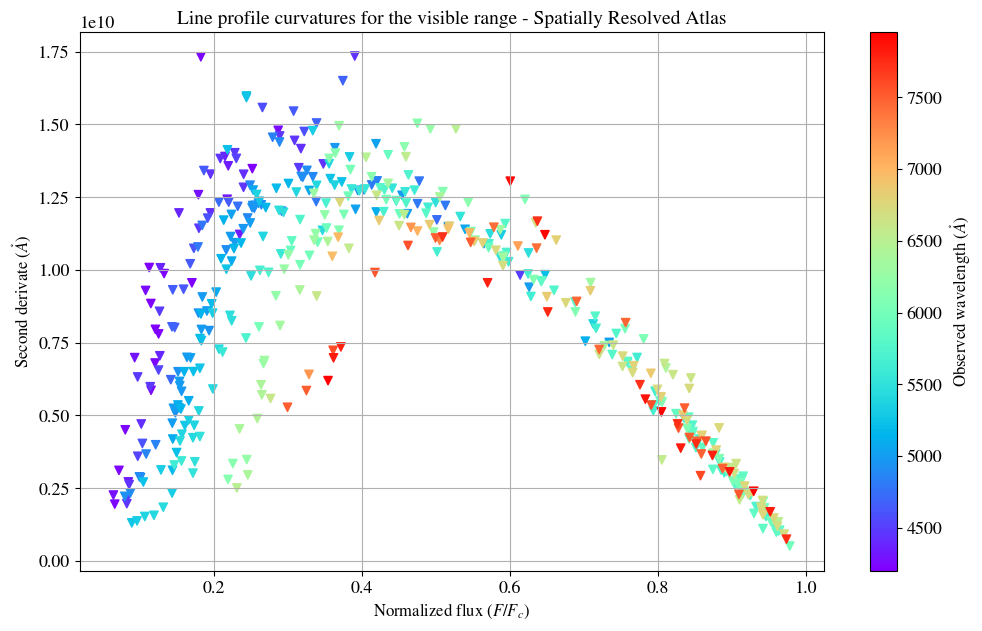

In [25]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Core curvature'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Line profile curvatures for the visible range - Spatially Resolved Atlas')
ax.set_xlabel(r'Normalized flux $(F/F_{c})$')
ax.set_ylabel(r'Second derivate $(\mathring{A})$')
ax.grid()

# fig4.savefig('Curvature_SPA.png')

### Third Derivate Expresion vs Normalized Flux

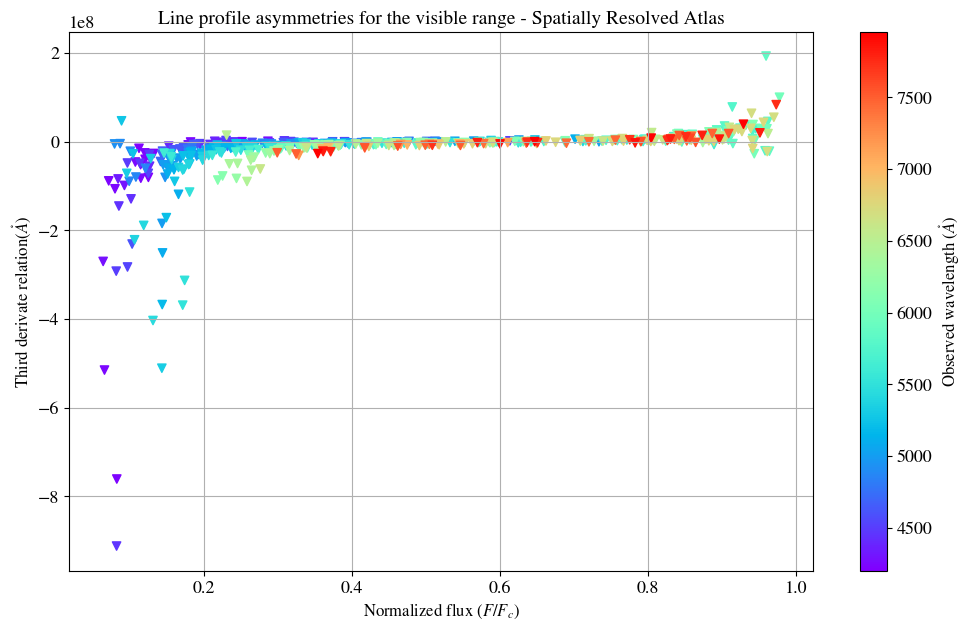

In [26]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Bisector slope'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Line profile asymmetries for the visible range - Spatially Resolved Atlas')
ax.set_xlabel(r'Normalized flux $(F/F_{c})$')
ax.set_ylabel(r'Third derivate relation$(\mathring{A})$')
ax.grid()

# fig5.savefig('CBisector_SPA.png')

### Convective Blueshift vs Line Depth

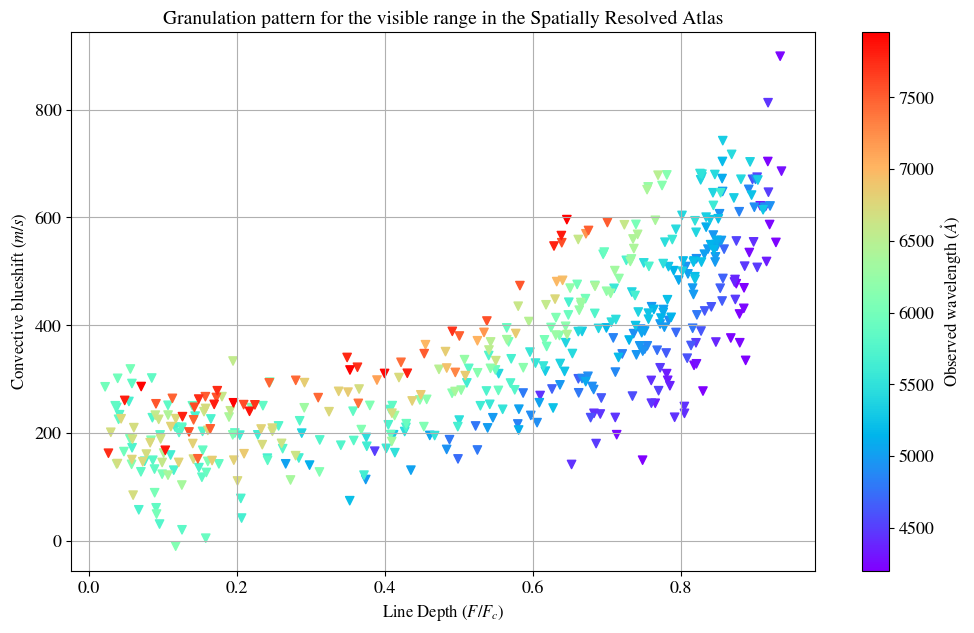

In [27]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Granulation pattern for the visible range in the Spatially Resolved Atlas')
ax.set_xlabel(r'Line Depth $(F/F_{c})$')
ax.set_ylabel(r'Convective blueshift $(m/s)$')
ax.grid()

# fig6.savefig('ConvectiveBlueshift_SPA.png')

## Statistics

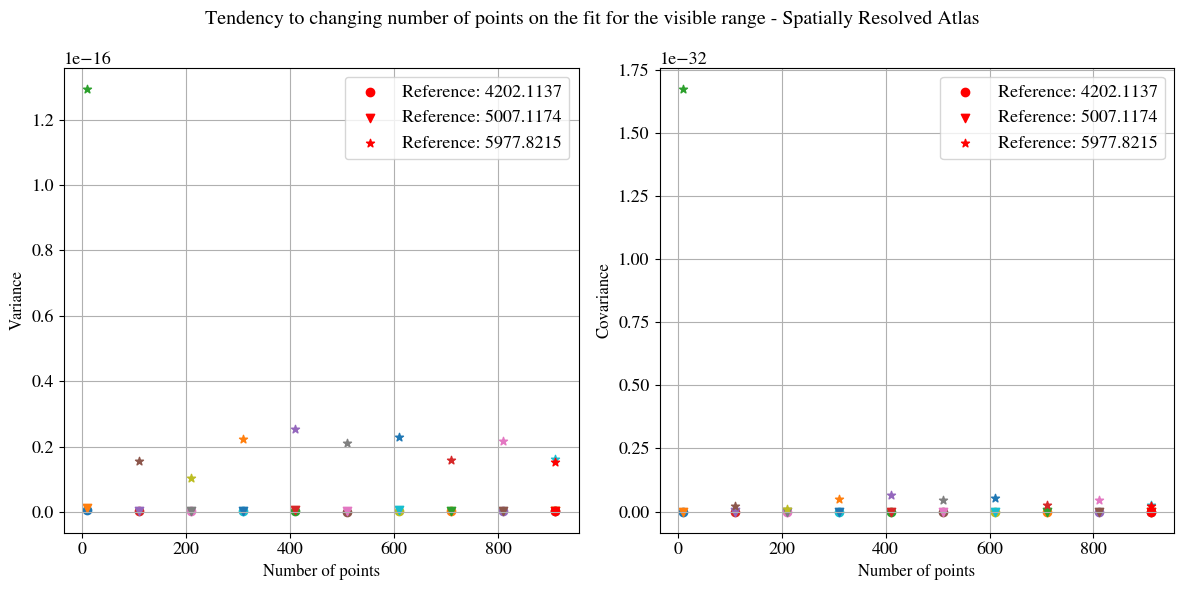

In [28]:
N_list = np.arange(10,1000,100) #Take different numbers for the 

fig7, axis1 = plt.subplots(1,2, figsize = (12,6))
ax1 = axis1[0]
ax2 = axis1[1]

fig7.suptitle(r'Tendency to changing number of points on the fit for the visible range - Spatially Resolved Atlas')

for each in N_list:
    Values_,Fit_,Cov_ = Fit_derivates(local_points,closer_lines['Fe line'],each)

    ax1.scatter(each, Cov_['Error'][0],marker='o')
    ax2.scatter(each, Cov_['Var'][0],marker='o')

    ax1.scatter(each, Cov_['Error'][122],marker='v')
    ax2.scatter(each, Cov_['Var'][122],marker='v')

    ax1.scatter(each, Cov_['Error'][300],marker='*')
    ax2.scatter(each, Cov_['Var'][300],marker='*')

ax1.scatter(each, Cov['Error'][0],marker='o',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][0]))
ax2.scatter(each, Cov['Var'][0],marker='o',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][0]))

ax1.scatter(each, Cov['Error'][122],marker='v',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][122]))
ax2.scatter(each, Cov['Var'][122],marker='v',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][122]))

ax1.scatter(each, Cov['Error'][300],marker='*',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][300]))
ax2.scatter(each, Cov['Var'][300],marker='*',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][300]))


ax1.grid()
ax1.legend()
ax1.set_xlabel(r'Number of points')
ax1.set_ylabel(r'Variance')
ax1.tick_params(axis='both')


ax2.grid()
ax2.legend()
ax2.set_xlabel(r'Number of points')
ax2.set_ylabel(r'Covariance')
ax2.tick_params(axis='both')

fig7.tight_layout()

# fig7.savefig('Covariance_SPA.pdf')

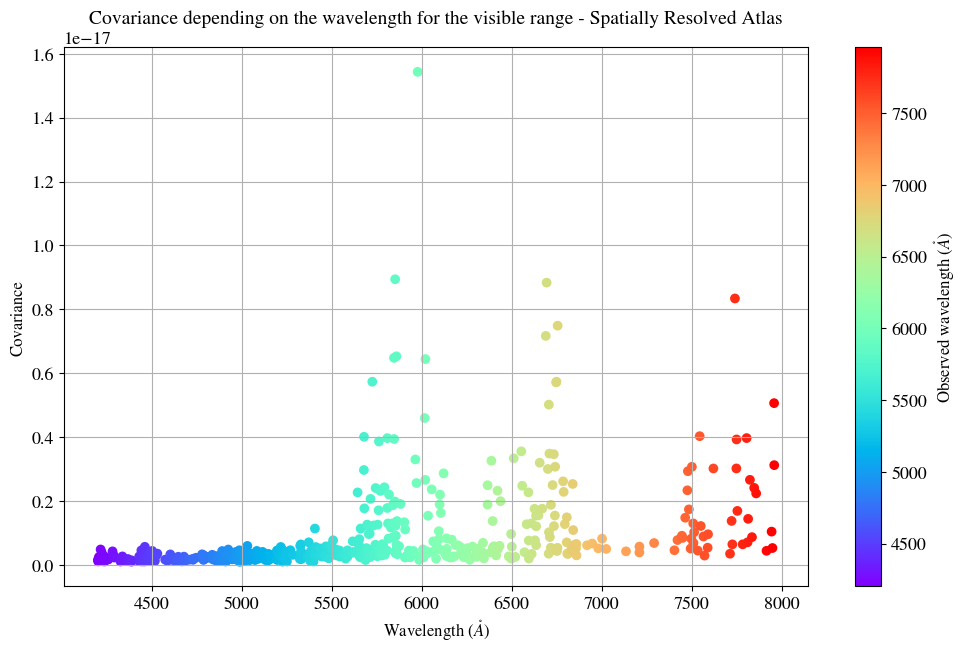

In [29]:
fig8, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values["Observed wavelength"],Cov['Error'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Covariance depending on the wavelength for the visible range - Spatially Resolved Atlas')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel(r'Covariance')
ax.grid()

# fig8.savefig('Cov_wave_SPA.pdf')